# Models

In [1]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
import sys
import numpy
import math
numpy.set_printoptions(threshold=sys.maxsize)

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.feature_selection import RFE

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold
seed(42)
import tensorflow as tf
tf.random.set_seed(38)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense

2022-01-03 08:18:20.294693: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-03 08:18:20.294729: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# load pre porcessed data
df = pd.read_csv('../prepross_data/data.csv')


#### Filterout the paper described patient set

In [3]:
# filter dataset as describe in paper
def get_filter_by_age_diabDur(df, age, diabDur):
    filter_patients = df[(df["AgeAtConsent"] >= age) & (df["diagDuration"] > diabDur)] 
#     filter_patients=filter_patients.drop_duplicates(subset="PtID",keep="first") 
    print(f'Number of patients whos age is {age}+ and diabetics duration greater than {diabDur}  is -> {filter_patients.PtID.size}')
    return filter_patients

df = get_filter_by_age_diabDur(df, 26, 2)

Number of patients whos age is 26+ and diabetics duration greater than 2  is -> 7155


### for SH events prediction pre processing


In [4]:
y_label = 'Pt_SevHypoEver' 
# possible labels Pt_SevHypoEver, SHSeizComaPast12mos, DKAPast12mos, Depression, DiabNeuro, DKADiag

In [5]:
# fill null value according to the other parameters

# fill with 0 - if data not available probably patient has not that medical condition
def fill_y_label(row):

    if(math.isnan(row['Pt_SevHypoEver'])):
        if((row['NumSHSeizComaPast12mos'] >= 1) or (row['Pt_v3NumSHSeizComa'] >= 1) or (row['SHSeizComaPast12mos'] >= 1)):
            row['Pt_SevHypoEver'] = 0
        else:
            row['Pt_SevHypoEver'] = 1
    return row


df = df.apply(fill_y_label, axis=1)


In [6]:
# get possible values in column including nan
def get_possible_vals_with_nan(df, colName):
    list_val =df[colName].unique().tolist()
    return list_val


# {'1.Yes': 0, '2.No': 1, "3.Don't know": 2}

print(df[y_label].unique())
get_possible_vals_with_nan(df, y_label)

# if(y_label == 'SHSeizComaPast12mos' ):
# #     df.drop(['NumSHSeizComaPast12mos','Pt_v3NumSHSeizComa','NumSHSeizComa', 'Pt_SevHypoEver'], inplace=True, axis=1) # add SHSeizComaPast12mos
#     df.drop(['NumSHSeizComaPast12mos','Pt_v3NumSHSeizComa'], inplace=True, axis=1) # add SHSeizComaPast12mos
#     df[y_label] = df[y_label].replace({2.0: 1.0})

if (y_label == 'Pt_SevHypoEver'):
#     df.drop(['NumSHSeizComaPast12mos','Pt_v3NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1) # add SHSeizComaPast12mos
    df[y_label] = df[y_label].replace({2.0: 0.0})


[1. 0. 2.]


In [7]:
pd.options.display.max_rows = 100

def get_missing_val_percentage(df):
    return (df.isnull().sum()* 100 / len(df))


missing_per = get_missing_val_percentage(df)

# get missing values < threshold feature name list
variables = df.columns
thresh = 40
variable = [ ]
var = []
for i in range(df.columns.shape[0]):
    if missing_per[i]<= thresh: #setting the threshold as 40%
        variable.append(variables[i])
    else :
        var.append(variables[i])
        
print("variables missing vals < threshold")     
print(variable)
print("Length: ", len(variable))

print()
print("variables missing vals > threshold")     
print(var)
print("Length: ", len(var))

variables missing vals < threshold
['PtID', 'Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag', 'Pt_NumHospDKA', 'Pt_InsulinRecMethod', 'Pt_MealBolusMethod', 'Pt_InsCarbRat', 'Pt_InsCarbRatBrkfst', 'Pt_InsCarbRatLunch', 'Pt_InsCarbRatDinn', 'Pt_BolusDaySnackFreq', 'Pt_BedtimeSnack', 'Pt_ChkBldSugPriBolus', 'Pt_MissInsDoseFreq', 'Pt_NumBolusDayUnk', 'Pt_InjLongActDayNotUsed', 'Pt_InjShortActDayNotUsed', 'Pt_LongActInsDayNotUsed', 'Pt_NumMeterCheckDay', 'Pt_DLoadHGMFreq', 'Pt_LogBook', 'Pt_ChkKetones', 'Pt_CGMUse', 'Pt_CGMStopUse', 'Pt_LastEyeExamPart', 'Pt_DiabRetTrtPart', 'Pt_LegBlind', 'Pt_GlutFreeDiet', 'Pt_CeliacDr', 'Pt_HighBldPrTrt', 'Pt_Smoke', 'Pt_GenHealth', 'Pt_StressDiab', 'Pt_AnnualInc', 'Pt_HouseholdCnt', 'Pt_InsPriv', 'Pt_MaritalStatus', 'Pt_EmployStatus', 'Pt_RaceEth', 'ReqInsulinCrit', 'DKADiag', 'OralAgnTrt', 'ExamDaysFromConsent', 'Gender', 'Weight', 'Height', 'BldPrSys', 'BldPrDia', 'InsulinDeliv', 'Lypohyper', 'Lipoatrophy', 'AcanNigrDiag', 'PulseRate', 'AcanNigrP

In [8]:
# cols_to_del = ['Diab_dur_greater','HbA1C_SH', 'Pt_InsHumalog', 'Pt_InsNovolog', 'Pt_BolusDecCntCarb', 
#                'Pt_BolusBedtimeSnackFreq', 'Pt_InsPumpStartAge', 'Pt_PumpManuf', 'Pt_PumpModel',
#                'Pt_DaysLeavePumpIns', 'Pt_BasInsRateChgDay', 'Pt_NumBolusDay', 'Pt_ReturnPump', 
#                'Pt_InjMethod', 'Pt_InjLongActDay', 'Pt_InjShortActDay', 'Pt_LongActInsDay', 
#                'Pt_ShortActInsDay', 'Pt_PumpStopUse', 'Pt_HealthProfDiabEdu', 'Pt_SmokeAmt', 
#                'Pt_DaysWkEx', 'Pt_MenarcheAge', 'Pt_RegMenstCyc', 'Pt_IrregMenstCycReas',
#                'Pt_CurrPreg', 'Pt_MiscarriageNum', 'Pt_v3NumHospOthReas',
#                'HyperglyCritRandGluc', 'WeightDiag', 'NumDKAOccur', 'TannerNotDone', 'PumpTotBasIns',
#                'HGMNumDays', 'HGMTestCntAvg', 'HGMGlucMean', 'CGMGlucPctBelow70', 'CGMGlucPctBelow60', 
#                'PulseRate', 'InsCarbRatBrkfst', 'InsCarbRatLunch', 'InsCarbRatDinn', 'InsCarbRatDinnNotUsed', 
#                'CGMPctBelow55', 'CGMPctBelow80']

cols_to_del = ['Diab_dur_greater']

df.drop(cols_to_del, inplace=True, axis=1)
df.head(10)

,PtID,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsHumalog,Pt_InsNovolog,Pt_InsApidra,Pt_InsRegular,...,CardiacArrhyth,Hemoglob,RheumArth,Osteo,Depression,Anxiety,Psychosis,DiabNeuro,diagDuration,education_level
0,3963.0,1.0,1.0,1.0,0.0,0.0,NaN,1.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876,11.0
4,12505.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684,12.0
5,3100.0,2.0,1.0,1.0,0.0,1.0,NaN,1.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.9514,11.0
7,26063.0,1.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507,NaN
14,553.0,0.0,1.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549,11.0
15,13365.0,0.0,0.0,1.0,0.0,0.0,NaN,1.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915,13.0
20,15799.0,3.0,1.0,2.0,0.0,1.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739,9.0
24,15966.0,0.0,1.0,1.0,0.0,0.0,NaN,1.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999,12.0
27,6426.0,1.0,1.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704,10.0
34,10659.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979,10.0


# Divide Dataset

In [9]:
df=df.drop('PtID', axis = 1)

In [10]:

def divide_data(df,label):
    Y = df[label]
    X = df.drop(label, axis=1)
    return X, Y

X, Y = divide_data(df, y_label)


In [11]:
Y.unique()

array([1., 0.])

# Feature Selection

In [12]:
shape = np.shape(X) 
feature = 25 #shape[1] 
n_classes = 2


In [13]:
seed(42)
tf.random.set_seed(38)
# Save original data set
original_X = X

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=123)
# if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)


In [14]:
len(Y_train == 0.0)
unique, counts = numpy.unique(Y_train.to_numpy(), return_counts=True)
print("Train - ", unique, counts)

unique_test, counts_test = numpy.unique(Y_test.to_numpy(), return_counts=True)
print("Test - ", unique_test, counts_test)


Train -  [0. 1.] [1860 3506]
Test -  [0. 1.] [ 620 1169]


# Imputations

<AxesSubplot:>

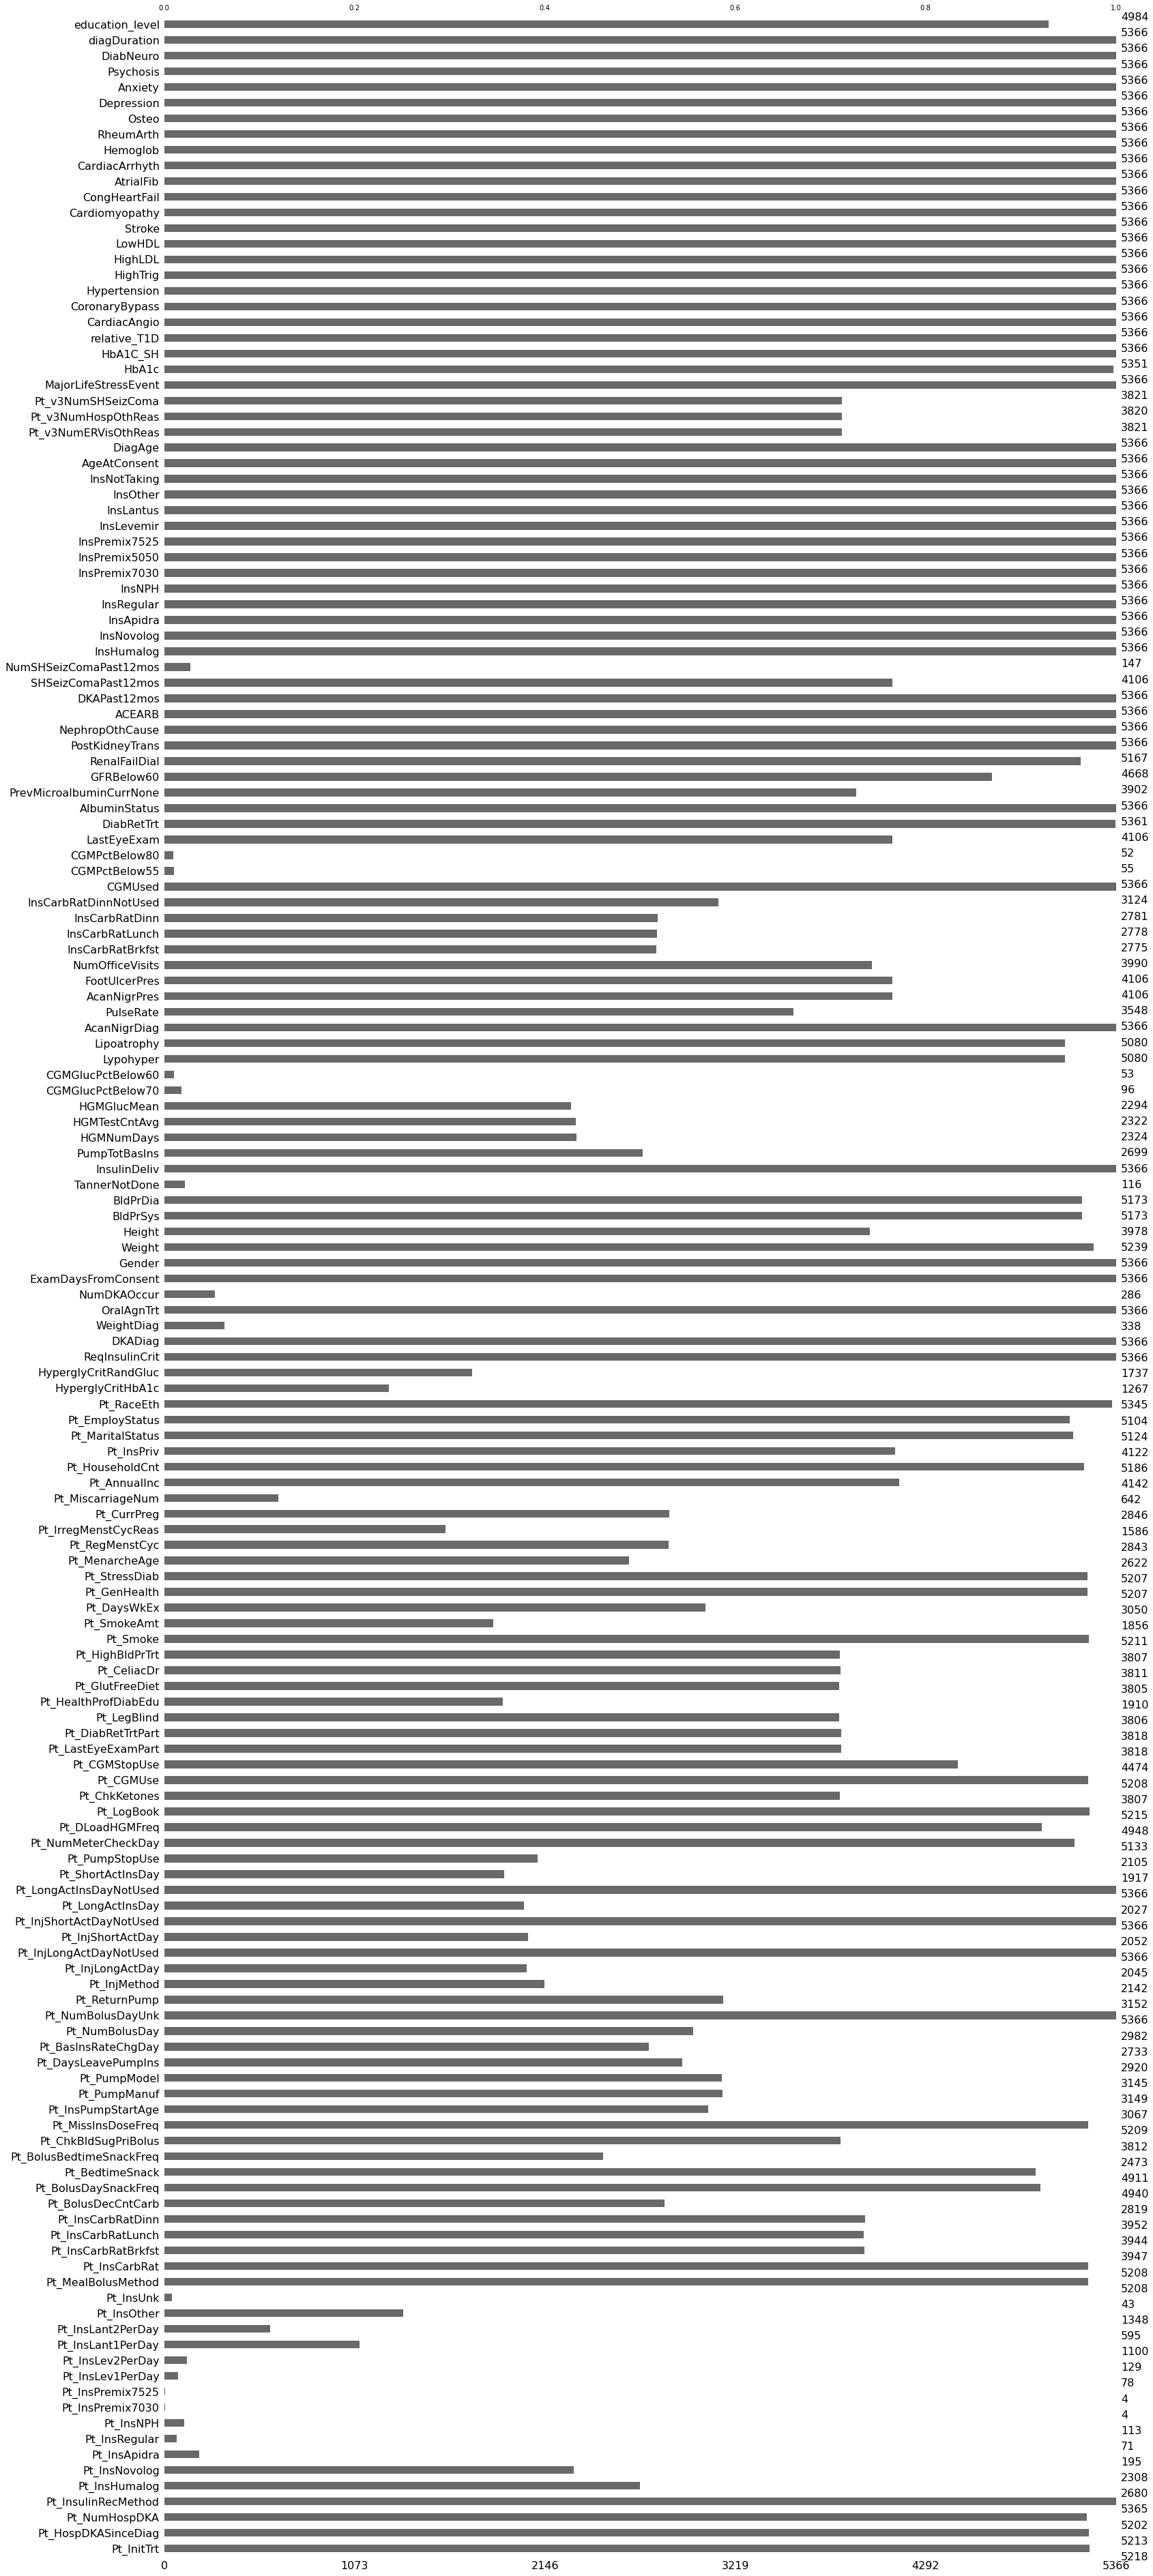

In [15]:
import missingno as msno
msno.bar(X_train)

### XGB with missing values

In [16]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [17]:
# use only for XGB classifier with missing values
X_train_copy = X_train.drop(['SHSeizComaPast12mos', 'NumSHSeizComaPast12mos', 'Pt_v3NumSHSeizComa'], axis=1)
X_test_copy = X_test.drop(['SHSeizComaPast12mos', 'NumSHSeizComaPast12mos', 'Pt_v3NumSHSeizComa'], axis=1)


In [18]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train_copy.copy()
train[y_label] = Y_train.values

def cross_val_with_missing_val(model):
#     i = 1
#     for train_index, test_index in kf.split(train):
#         X_train1 = train.iloc[train_index].loc[:, X_train.columns]
#         X_test1 = train.iloc[test_index][X_train.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index][y_label]

#         #Train the model
#         model.fit(X_train1, y_train1) #Training the model
#         print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}")
#         i += 1
#     return model



    dfs = []
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train_copy.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")

        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1
    return model



Accuracy for the fold no. 1 on the test set: 0.7430167597765364, doublecheck: 0.7430167597765364
Accuracy for the fold no. 2 on the test set: 0.7281191806331471, doublecheck: 0.7281191806331471
Accuracy for the fold no. 3 on the test set: 0.7728119180633147, doublecheck: 0.7728119180633147
Accuracy for the fold no. 4 on the test set: 0.7653631284916201, doublecheck: 0.7653631284916201
Accuracy for the fold no. 5 on the test set: 0.7560521415270018, doublecheck: 0.7560521415270018
Accuracy for the fold no. 6 on the test set: 0.7635009310986964, doublecheck: 0.7635009310986964
Accuracy for the fold no. 7 on the test set: 0.7332089552238806, doublecheck: 0.7332089552238806
Accuracy for the fold no. 8 on the test set: 0.7705223880597015, doublecheck: 0.7705223880597015
Accuracy for the fold no. 9 on the test set: 0.7779850746268657, doublecheck: 0.7779850746268657
Accuracy for the fold no. 10 on the test set: 0.7723880597014925, doublecheck: 0.7723880597014925

 
 ===========   Train Datas

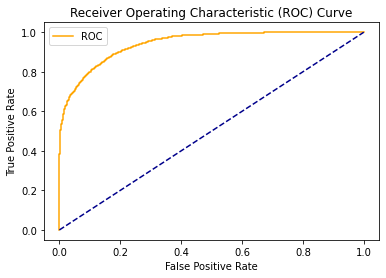

accuracy score:  86.00447260529258
              precision    recall  f1-score   support

         0.0       0.77      0.84      0.81      1860
         1.0       0.91      0.87      0.89      3506

    accuracy                           0.86      5366
   macro avg       0.84      0.86      0.85      5366
weighted avg       0.86      0.86      0.86      5366



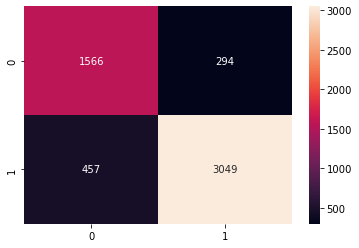

Accuracy of XGB on training set: 0.87


 ===========   Test Dataset    =============
Threshold value is: 0.7544071


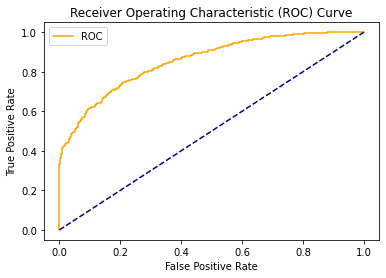

accuracy score:  76.18781442146451
              precision    recall  f1-score   support

         0.0       0.62      0.79      0.70       620
         1.0       0.87      0.75      0.80      1169

    accuracy                           0.76      1789
   macro avg       0.75      0.77      0.75      1789
weighted avg       0.79      0.76      0.77      1789



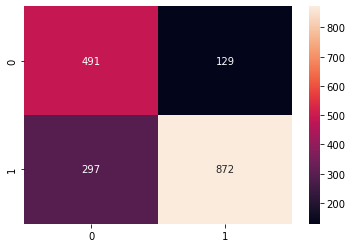

Accuracy of XGB classifier on test set: 0.78


 ===========   ROC    =============
roc_auc = 0.8556


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.79193548 0.7459367 ]
average accuracy:  0.7689360909517371


In [19]:
# xgboost - train with missing values

model=XGBClassifier(
        use_label_encoder=False, eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
        max_delta_step = 10,
#         scale_pos_weight = 0.4,
#         n_jobs = 0,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
    )
                   
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)



print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)




<AxesSubplot:>

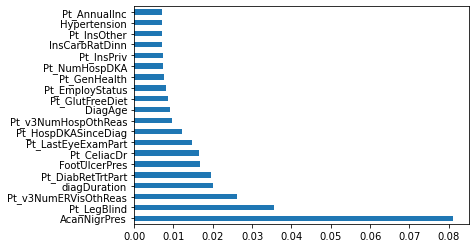

In [20]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:162])
feat_importances.nlargest(20).plot(kind='barh')

In [21]:
X_train.update(X_train[[
             'Pt_InsPriv', 'Pt_InsHumalog', 'Pt_InsNovolog','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
             'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone','Pt_InsApidra',
             'Pt_InsRegular','Pt_InsNPH','Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay',
             'Pt_InsOther',]].fillna(0))

X_test.update(X_test[[
             'Pt_InsPriv', 'Pt_InsHumalog', 'Pt_InsNovolog','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
             'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone','Pt_InsApidra',
             'Pt_InsRegular','Pt_InsNPH','Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay',
             'Pt_InsOther',]].fillna(0))

/usr/lib/python3/dist-packages/pandas/core/frame.py:6397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [22]:
# fill nan values in categorical dataset with frequent value

# tested wuth mean and median - results is lower than most_frequent
imputeX = SimpleImputer(missing_values=np.nan, strategy = "most_frequent")
# imputeX = KNNImputer(missing_values=np.nan, n_neighbors = 3, weights='distance')
# imputeX = IterativeImputer(max_iter=5, random_state=0)

X_train = imputeX.fit_transform(X_train)


In [23]:
# test data imputation

Test = X_test.copy()
Test.loc[:,y_label] = Y_test

X_test = imputeX.transform(X_test)



# Scale data

In [24]:
# Normalize numeric features
scaler = StandardScaler()
# scaler = MinMaxScaler()
select = {}
select[0] = pd.DataFrame(scaler.fit_transform(X_train))
select[1] = Y_train
select[2] = pd.DataFrame(scaler.transform(X_test))


## Feature Selection

In [25]:
# TODO

# def select_features(select, feature):
#     selected = {}
#     fs = SelectKBest(score_func=mutual_info_classif, k=feature) # k=feature score_func SelectPercentile
#     selected[0] = fs.fit_transform(select[0], select[1])
#     selected[1] = fs.transform(select[2])
        
#     idx = fs.get_support(indices=True)
    
#     return selected, fs, idx



In [26]:


#Selecting the Best important features according to Logistic Regression
# Give better performance than selectKBest 
def select_features(select, feature):
    selected = {}
#     fs = RFE(estimator=LogisticRegression(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    fs = RFE(estimator=XGBClassifier(), n_features_to_select=feature, step = 5) #  step (the number of features eliminated each iteration) 
#     fs = RFE(estimator=RandomForestClassifier(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    
    
    selected[0] = fs.fit_transform(select[0], select[1])
    selected[1] = fs.transform(select[2])
        
    idx = fs.get_support(indices=True)
    
    return selected, fs, idx


In [27]:
# Feature selection
selected, fs, idx = select_features(select, feature)


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:24:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:25:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:25:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:25:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:25:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:25:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:25:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:25:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:25:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:25:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:25:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:26:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:26:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:26:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:26:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:26:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:26:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:26:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:26:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:26:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:26:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:26:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:26:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:26:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:26:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:26:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:26:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:26:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:26:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [28]:
# Get columns to keep and create new dataframe with those only
from pprint import pprint
cols = fs.get_support(indices=True)
features_df_new = original_X.iloc[:,cols]
pprint(features_df_new.columns)
print(features_df_new.shape)

Index(['Pt_InitTrt', 'Pt_HospDKASinceDiag', 'Pt_InsHumalog', 'Pt_InsNovolog',
       'Pt_ChkBldSugPriBolus', 'Pt_NumBolusDay', 'Pt_ReturnPump',
       'Pt_ChkKetones', 'Pt_LastEyeExamPart', 'Pt_DiabRetTrtPart',
       'Pt_HighBldPrTrt', 'Pt_DaysWkEx', 'Pt_StressDiab', 'Pt_MenarcheAge',
       'AcanNigrDiag', 'PulseRate', 'NumOfficeVisits', 'InsCarbRatBrkfst',
       'InsCarbRatDinn', 'LastEyeExam', 'PrevMicroalbuminCurrNone',
       'DKAPast12mos', 'SHSeizComaPast12mos', 'Pt_v3NumSHSeizComa',
       'diagDuration'],
      dtype='object')
(7155, 25)


In [29]:
X_train = pd.DataFrame(selected[0], columns = features_df_new.columns)
X_test = pd.DataFrame(selected[1], columns = features_df_new.columns)


In [30]:
# X_train.drop(['Pt_v3NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1)
# X_test.drop(['Pt_v3NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1)

if('SHSeizComaPast12mos' in X_train.columns):
    X_train = X_train.drop(['SHSeizComaPast12mos'], axis=1)
    X_test = X_test.drop(['SHSeizComaPast12mos'], axis=1)
if('NumSHSeizComaPast12mos' in X_train.columns):
    X_train = X_train.drop(['NumSHSeizComaPast12mos'], axis=1)
    X_test = X_test.drop([ 'NumSHSeizComaPast12mos'], axis=1)
if('Pt_v3NumSHSeizComa' in X_train.columns):
    X_train = X_train.drop(['Pt_v3NumSHSeizComa'], axis=1)
    X_test = X_test.drop(['Pt_v3NumSHSeizComa'], axis=1)


### Common functions

In [31]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train.copy()
train[y_label] = Y_train.values

def cross_val(model):
#     i = 1
#     for train_index, test_index in kf.split(train):
#         X_train1 = train.iloc[train_index].loc[:, X_train.columns]
#         X_ test1 = train.iloc[test_index][X_train.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index][y_label]

#         #Train the model
#         model.fit(X_train1, y_train1) #Training the model
#         print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}")
#         i += 1
#     return model



    dfs = []
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")

        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1
    return model



In [32]:
def optimal_thresh(model, X, Y):
    y_scores = model.predict_proba(X)[:,1]

    fpr, tpr, thresholds = roc_curve(Y, y_scores)
    print(roc_auc_score(Y, y_scores))
#     optimal_idx = np.argmax(sqrt(tpr * (1-fpr)))
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    plot_roc_curve(fpr, tpr)
    return optimal_threshold

In [33]:
def train_results(model, X_train, Y_train, pred_train):
    print("\n \n =====================   Train Dataset    ======================")

    print(accuracy_score(Y_train, pred_train)*100)

    confusion_matrix_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
    sns.heatmap(confusion_matrix_train, annot=True,fmt='g')
    print(classification_report(Y_train, pred_train))
    plt.show()
    
    train_acc = model.score(X_train, Y_train)
    print('Accuracy of on training set: {:.2f}'.format(train_acc))

def test_results(model, X_test, Y_test, pred):
    print("\n\n =====================   Test Dataset    =======================")

    print(accuracy_score(Y_test, pred)*100)

    confusion_matrix_model = confusion_matrix(Y_test, pred)
    sns.heatmap(confusion_matrix_model, annot=True,fmt='g')
    print(classification_report(Y_test, pred))
    plt.show()
    
    test_acc = model.score(X_test, Y_test)
    print('Accuracy of classifier on test set: {:.2f}'
         .format(test_acc))

def ROC_results(model, X_test, Y_test):
    print("\n\n =======================   Test-ROC    =========================")

    y_scores = model.predict_proba(X_test)
    score = roc_auc_score(Y_test, y_scores[:, 1])
    score = round(score,4)
    print(f'roc_auc = {score}')
    
def class_wise_test_accuracy(model, Y_test, pred):
    print("\n\n =======================   Class-wise test accuracy    =====================")
    confusion_matrix_model = confusion_matrix(Y_test, pred)
    acc = confusion_matrix_model.diagonal()/confusion_matrix_model.sum(axis=1)
    print('classwise accuracy [class 0, class 1]: ',(acc))
    print('average accuracy: ',( np.sum(acc)/2))

### Adaboost model

Accuracy for the fold no. 1 on the test set: 0.6890130353817505, doublecheck: 0.6890130353817505
Accuracy for the fold no. 2 on the test set: 0.6871508379888268, doublecheck: 0.6871508379888268
Accuracy for the fold no. 3 on the test set: 0.6945996275605214, doublecheck: 0.6945996275605214
Accuracy for the fold no. 4 on the test set: 0.7318435754189944, doublecheck: 0.7318435754189944
Accuracy for the fold no. 5 on the test set: 0.7132216014897579, doublecheck: 0.7132216014897579
Accuracy for the fold no. 6 on the test set: 0.6964618249534451, doublecheck: 0.6964618249534451
Accuracy for the fold no. 7 on the test set: 0.710820895522388, doublecheck: 0.710820895522388
Accuracy for the fold no. 8 on the test set: 0.7182835820895522, doublecheck: 0.7182835820895522
Accuracy for the fold no. 9 on the test set: 0.6921641791044776, doublecheck: 0.6921641791044776
Accuracy for the fold no. 10 on the test set: 0.6865671641791045, doublecheck: 0.6865671641791045
0.7783444631474379
Threshold va

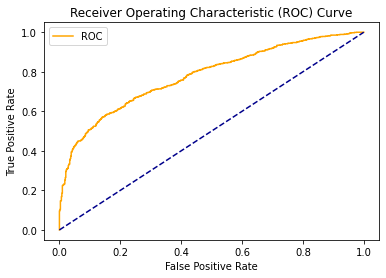

0.7830851412938802
Threshold value is: 0.5053010607115154


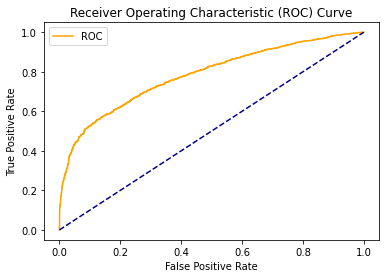


 
 =====================   Train Dataset    ======================
67.14498695490123
              precision    recall  f1-score   support

         0.0       0.52      0.86      0.65      1860
         1.0       0.89      0.57      0.69      3506

    accuracy                           0.67      5366
   macro avg       0.70      0.72      0.67      5366
weighted avg       0.76      0.67      0.68      5366



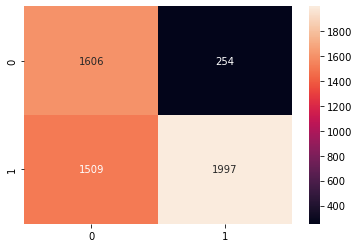

Accuracy of on training set: 0.71


 =====================   Test Dataset    =======================
67.07657909446618
              precision    recall  f1-score   support

         0.0       0.51      0.86      0.64       620
         1.0       0.88      0.57      0.69      1169

    accuracy                           0.67      1789
   macro avg       0.70      0.72      0.67      1789
weighted avg       0.76      0.67      0.68      1789



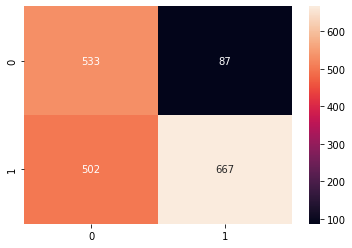

Accuracy of classifier on test set: 0.71


 =======================   Test-ROC    =========================
roc_auc = 0.7783


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.85967742 0.57057314]
average accuracy:  0.7151252793951268


In [34]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

adaboost = AdaBoostClassifier(random_state=0, learning_rate=0.05, n_estimators=1000, algorithm = "SAMME.R") #algorithm{‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’

# adaboost.fit(X_train, Y_train)
adaboost = cross_val(adaboost)

# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(adaboost, X_test, Y_test)
pred = (adaboost.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

optimal_threshold_train= optimal_thresh(adaboost, X_train, Y_train)
pred_train = (adaboost.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

# test and train results
train_results(adaboost, X_train, Y_train, pred_train)
test_results(adaboost, X_test, Y_test, pred)

# ROC
ROC_results(adaboost, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(adaboost, Y_test, pred)


<AxesSubplot:>

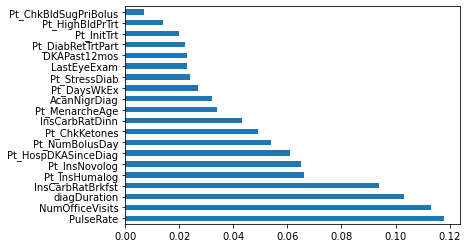

In [35]:
feat_importances = pd.Series(adaboost.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

# Model - XGB

Accuracy for the fold no. 1 on the test set: 0.7057728119180633, doublecheck: 0.7057728119180633
Accuracy for the fold no. 2 on the test set: 0.7150837988826816, doublecheck: 0.7150837988826816
Accuracy for the fold no. 3 on the test set: 0.7188081936685289, doublecheck: 0.7188081936685289
Accuracy for the fold no. 4 on the test set: 0.7672253258845437, doublecheck: 0.7672253258845437
Accuracy for the fold no. 5 on the test set: 0.7374301675977654, doublecheck: 0.7374301675977654
Accuracy for the fold no. 6 on the test set: 0.7243947858472998, doublecheck: 0.7243947858472998
Accuracy for the fold no. 7 on the test set: 0.753731343283582, doublecheck: 0.753731343283582
Accuracy for the fold no. 8 on the test set: 0.7667910447761194, doublecheck: 0.7667910447761194
Accuracy for the fold no. 9 on the test set: 0.7294776119402985, doublecheck: 0.7294776119402985
Accuracy for the fold no. 10 on the test set: 0.7332089552238806, doublecheck: 0.7332089552238806
0.8116821656226717
Threshold va

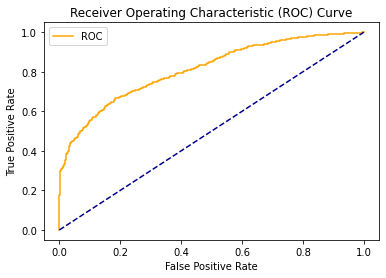

0.8887569849535972
Threshold value is: 0.679675


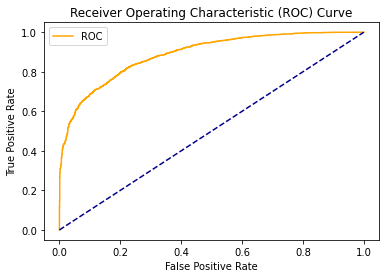


 
 =====================   Train Dataset    ======================
79.79873276183376
              precision    recall  f1-score   support

         0.0       0.68      0.80      0.73      1860
         1.0       0.88      0.80      0.84      3506

    accuracy                           0.80      5366
   macro avg       0.78      0.80      0.79      5366
weighted avg       0.81      0.80      0.80      5366



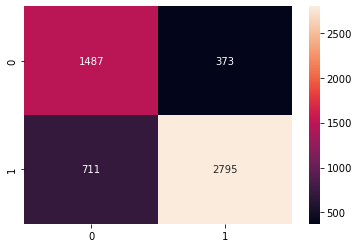

Accuracy of on training set: 0.81


 =====================   Test Dataset    =======================
71.77193963107882
              precision    recall  f1-score   support

         0.0       0.56      0.82      0.67       620
         1.0       0.87      0.67      0.75      1169

    accuracy                           0.72      1789
   macro avg       0.72      0.74      0.71      1789
weighted avg       0.77      0.72      0.72      1789



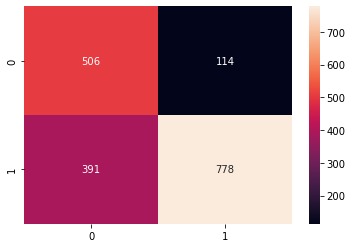

Accuracy of classifier on test set: 0.73


 =======================   Test-ROC    =========================
roc_auc = 0.8117


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.81612903 0.66552609]
average accuracy:  0.740827561466928


In [36]:
# xgboost - train with missing values


xgb_impute=XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
        max_delta_step = 10,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
        )
        
# xgb_impute.fit(X_train,Y_train)
xgb_impute = cross_val(xgb_impute)

# xgb_pred=xgb_impute.predict(X_test)
# xgb_pred_train=xgb_impute.predict(X_train)


# find optimal threshold
optimal_threshold = optimal_thresh(xgb_impute, X_test, Y_test)
optimal_threshold_train= optimal_thresh(xgb_impute, X_train, Y_train)

xgb_pred = (xgb_impute.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
xgb_pred_train = (xgb_impute.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(xgb_impute, X_train, Y_train, xgb_pred_train)
test_results(xgb_impute, X_test, Y_test, xgb_pred)

# ROC
ROC_results(xgb_impute, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(xgb_impute, Y_test, xgb_pred)



<AxesSubplot:>

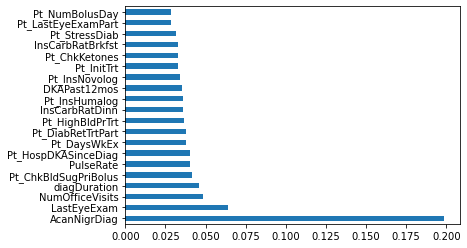

In [37]:
# feature importance graph of XGB
feat_importances = pd.Series(xgb_impute.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 2 - Random forest

Accuracy for the fold no. 1 on the test set: 0.6945996275605214, doublecheck: 0.6945996275605214
Accuracy for the fold no. 2 on the test set: 0.6964618249534451, doublecheck: 0.6964618249534451
Accuracy for the fold no. 3 on the test set: 0.7281191806331471, doublecheck: 0.7281191806331471
Accuracy for the fold no. 4 on the test set: 0.7411545623836127, doublecheck: 0.7411545623836127
Accuracy for the fold no. 5 on the test set: 0.6945996275605214, doublecheck: 0.6945996275605214
Accuracy for the fold no. 6 on the test set: 0.7206703910614525, doublecheck: 0.7206703910614525
Accuracy for the fold no. 7 on the test set: 0.7294776119402985, doublecheck: 0.7294776119402985
Accuracy for the fold no. 8 on the test set: 0.7425373134328358, doublecheck: 0.7425373134328358
Accuracy for the fold no. 9 on the test set: 0.7313432835820896, doublecheck: 0.7313432835820896
Accuracy for the fold no. 10 on the test set: 0.7014925373134329, doublecheck: 0.7014925373134329
0.8153591434642236
Threshold 

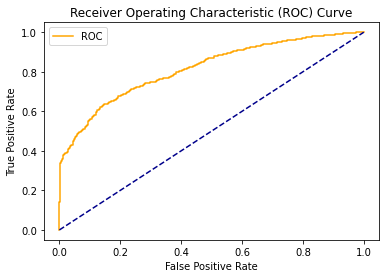

0.92744205018739
Threshold value is: 0.44319573549957875


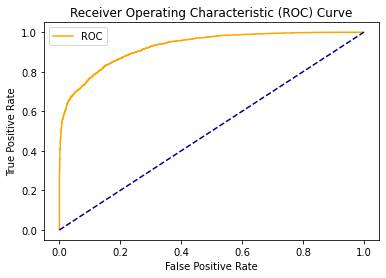


 
 =====================   Train Dataset    ======================
83.80544166977263
              precision    recall  f1-score   support

         0.0       0.73      0.85      0.78      1860
         1.0       0.91      0.83      0.87      3506

    accuracy                           0.84      5366
   macro avg       0.82      0.84      0.83      5366
weighted avg       0.85      0.84      0.84      5366



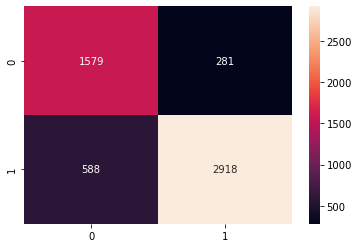

Accuracy of on training set: 0.80


 =====================   Test Dataset    =======================
71.15707098937955
              precision    recall  f1-score   support

         0.0       0.55      0.85      0.67       620
         1.0       0.89      0.64      0.74      1169

    accuracy                           0.71      1789
   macro avg       0.72      0.75      0.71      1789
weighted avg       0.77      0.71      0.72      1789



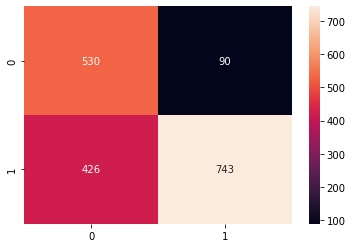

Accuracy of classifier on test set: 0.72


 =======================   Test-ROC    =========================
roc_auc = 0.8154


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.85483871 0.63558597]
average accuracy:  0.7452123402963657


In [38]:
#  random forest classifier

rf=RandomForestClassifier(max_depth=10,
#                              n_estimators = feature,
                             criterion = 'entropy', # {“gini”, “entropy”}, default=”gini”
                             class_weight = 'balanced_subsample', # {“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
                             ccp_alpha=0.001,
                             random_state=0)

# rf.fit(X_train,Y_train)
rf = cross_val(rf)

# find optimal threshold
optimal_threshold = optimal_thresh(rf, X_test, Y_test)
optimal_threshold_train= optimal_thresh(rf, X_train, Y_train)

# pred=rf.predict(X_test)
pred = (rf.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# pred_train=rf.predict(X_train)
pred_train = (rf.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(rf, X_train, Y_train, pred_train)
test_results(rf, X_test, Y_test, pred)

# ROC
ROC_results(rf, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(rf, Y_test, pred)

<AxesSubplot:>

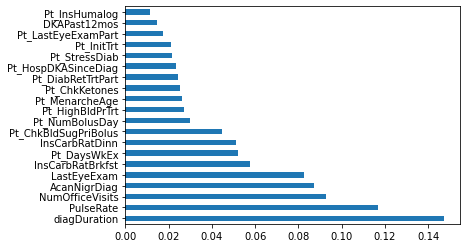

In [39]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 3 LogisticRegression

/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "


Accuracy for the fold no. 1 on the test set: 0.6573556797020484, doublecheck: 0.6573556797020484
Accuracy for the fold no. 2 on the test set: 0.6219739292364991, doublecheck: 0.6219739292364991


/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "


Accuracy for the fold no. 3 on the test set: 0.6554934823091247, doublecheck: 0.6554934823091247
Accuracy for the fold no. 4 on the test set: 0.7057728119180633, doublecheck: 0.7057728119180633


/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "


Accuracy for the fold no. 5 on the test set: 0.6722532588454376, doublecheck: 0.6722532588454376
Accuracy for the fold no. 6 on the test set: 0.6703910614525139, doublecheck: 0.6703910614525139


/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "


Accuracy for the fold no. 7 on the test set: 0.7033582089552238, doublecheck: 0.7033582089552238
Accuracy for the fold no. 8 on the test set: 0.6772388059701493, doublecheck: 0.6772388059701493


/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "


Accuracy for the fold no. 9 on the test set: 0.6623134328358209, doublecheck: 0.6623134328358209
Accuracy for the fold no. 10 on the test set: 0.6753731343283582, doublecheck: 0.6753731343283582


/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "


0.7378335494908801
Threshold value is: 0.5068514422693852


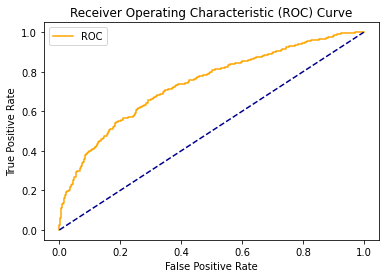

0.7414035232995357
Threshold value is: 0.5751229119239067


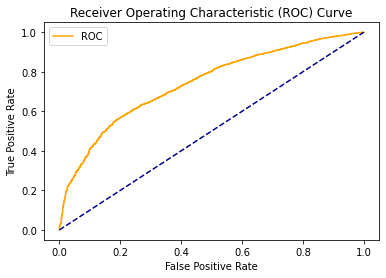


 
 =====================   Train Dataset    ======================
64.90868430860976
              precision    recall  f1-score   support

         0.0       0.50      0.80      0.61      1860
         1.0       0.84      0.57      0.68      3506

    accuracy                           0.65      5366
   macro avg       0.67      0.68      0.65      5366
weighted avg       0.72      0.65      0.66      5366



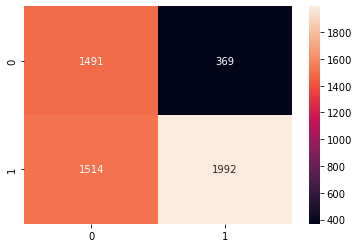

Accuracy of on training set: 0.67


 =====================   Test Dataset    =======================
67.35606484069312
              precision    recall  f1-score   support

         0.0       0.52      0.71      0.60       620
         1.0       0.81      0.66      0.72      1169

    accuracy                           0.67      1789
   macro avg       0.67      0.68      0.66      1789
weighted avg       0.71      0.67      0.68      1789



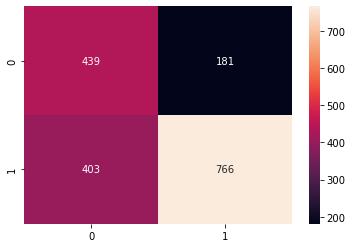

Accuracy of classifier on test set: 0.67


 =======================   Test-ROC    =========================
roc_auc = 0.7378


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.70806452 0.65526091]
average accuracy:  0.6816627114434725


In [40]:
#penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
logreg = LogisticRegression(
    penalty='l2',
    tol = 5e-4,
    C=1,
    l1_ratio = 10,
    class_weight='balanced',  # balanced
    random_state=0,
    solver = 'saga' # saga, sag
)

# logreg.fit(X_train, Y_train)
logreg = cross_val(logreg)

# pred=logreg.predict(X_test)
# pred_train=logreg.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(logreg, X_test, Y_test)
optimal_threshold_train= optimal_thresh(logreg, X_train, Y_train)

pred = (logreg.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (logreg.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(logreg, X_train, Y_train, pred_train)
test_results(logreg, X_test, Y_test, pred)

# ROC
ROC_results(logreg, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(logreg, Y_test, pred)

<AxesSubplot:>

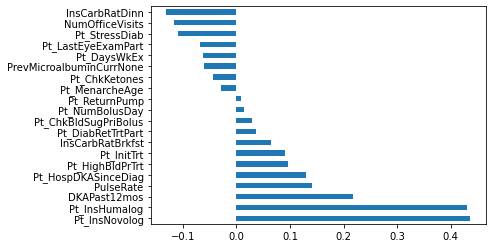

In [41]:

feat_importances = pd.Series(logreg.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 4 - Decision tree

Accuracy for the fold no. 1 on the test set: 0.6722532588454376, doublecheck: 0.6722532588454376
Accuracy for the fold no. 2 on the test set: 0.6480446927374302, doublecheck: 0.6480446927374302
Accuracy for the fold no. 3 on the test set: 0.6722532588454376, doublecheck: 0.6722532588454376
Accuracy for the fold no. 4 on the test set: 0.6797020484171322, doublecheck: 0.6797020484171322
Accuracy for the fold no. 5 on the test set: 0.6368715083798883, doublecheck: 0.6368715083798883
Accuracy for the fold no. 6 on the test set: 0.6350093109869647, doublecheck: 0.6350093109869647
Accuracy for the fold no. 7 on the test set: 0.6735074626865671, doublecheck: 0.6735074626865671
Accuracy for the fold no. 8 on the test set: 0.6735074626865671, doublecheck: 0.6735074626865671
Accuracy for the fold no. 9 on the test set: 0.6865671641791045, doublecheck: 0.6865671641791045
Accuracy for the fold no. 10 on the test set: 0.6772388059701493, doublecheck: 0.6772388059701493
0.6308990314302272
Threshold 

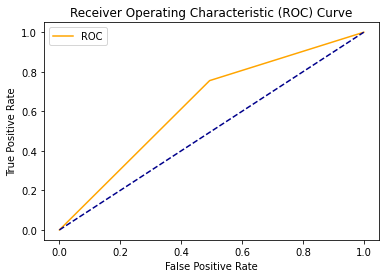

0.9644744186617106
Threshold value is: 1.0


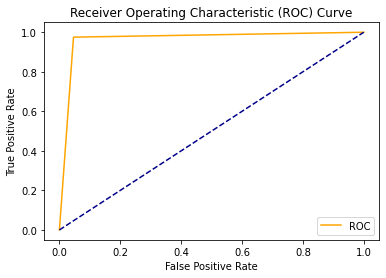


 
 =====================   Train Dataset    ======================
96.77599701826314
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      1860
         1.0       0.98      0.98      0.98      3506

    accuracy                           0.97      5366
   macro avg       0.96      0.96      0.96      5366
weighted avg       0.97      0.97      0.97      5366



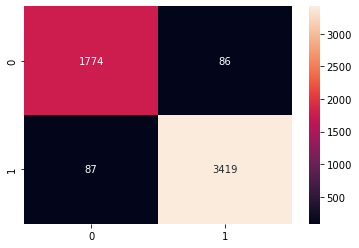

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
66.90888764673002
              precision    recall  f1-score   support

         0.0       0.52      0.51      0.51       620
         1.0       0.74      0.76      0.75      1169

    accuracy                           0.67      1789
   macro avg       0.63      0.63      0.63      1789
weighted avg       0.67      0.67      0.67      1789



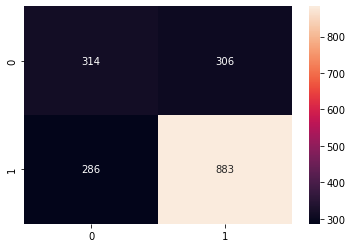

Accuracy of classifier on test set: 0.67


 =======================   Test-ROC    =========================
roc_auc = 0.6309


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.50645161 0.75534645]
average accuracy:  0.6308990314302272


In [42]:
clf = DecisionTreeClassifier(
                        random_state=0,
                        criterion='gini',
                        splitter = 'best',
                        max_depth = 100,
                        max_features = 20)
# clf.fit(X_train, Y_train)
clf = cross_val(clf)

# pred=clf.predict(X_test)
# pred_train=clf.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(clf, X_test, Y_test)
optimal_threshold_train= optimal_thresh(clf, X_train, Y_train)

pred = (clf.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (clf.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(clf, X_train, Y_train, pred_train)
test_results(clf, X_test, Y_test, pred)

# ROC
ROC_results(clf, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(clf, Y_test, pred)

<AxesSubplot:>

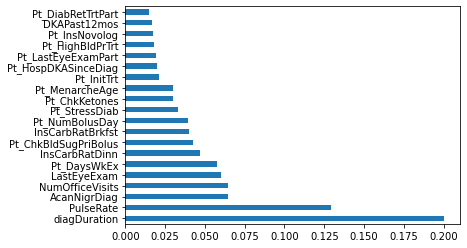

In [43]:

feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 5 - K-Nearest Neighbors

Accuracy for the fold no. 1 on the test set: 0.6480446927374302, doublecheck: 0.6480446927374302
Accuracy for the fold no. 2 on the test set: 0.664804469273743, doublecheck: 0.664804469273743
Accuracy for the fold no. 3 on the test set: 0.638733705772812, doublecheck: 0.638733705772812
Accuracy for the fold no. 4 on the test set: 0.7243947858472998, doublecheck: 0.7243947858472998
Accuracy for the fold no. 5 on the test set: 0.6741154562383612, doublecheck: 0.6741154562383612
Accuracy for the fold no. 6 on the test set: 0.6368715083798883, doublecheck: 0.6368715083798883
Accuracy for the fold no. 7 on the test set: 0.6902985074626866, doublecheck: 0.6902985074626866
Accuracy for the fold no. 8 on the test set: 0.710820895522388, doublecheck: 0.710820895522388
Accuracy for the fold no. 9 on the test set: 0.6735074626865671, doublecheck: 0.6735074626865671
Accuracy for the fold no. 10 on the test set: 0.6753731343283582, doublecheck: 0.6753731343283582
0.6265859985098927
Threshold value 

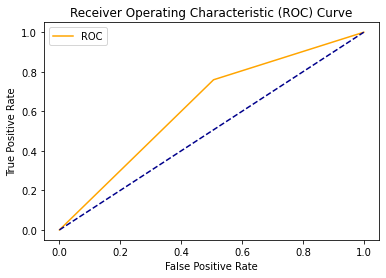

0.9637007832962233
Threshold value is: 1.0


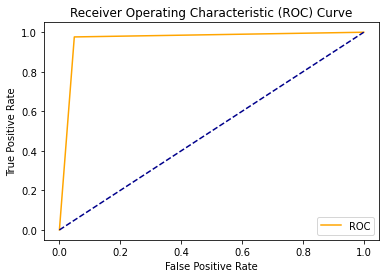


 
 =====================   Train Dataset    ======================
96.75736116287737
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95      1860
         1.0       0.97      0.98      0.98      3506

    accuracy                           0.97      5366
   macro avg       0.96      0.96      0.96      5366
weighted avg       0.97      0.97      0.97      5366



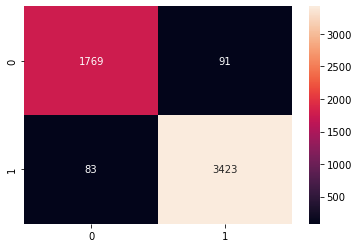

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
66.74119619899385
              precision    recall  f1-score   support

         0.0       0.52      0.49      0.51       620
         1.0       0.74      0.76      0.75      1169

    accuracy                           0.67      1789
   macro avg       0.63      0.63      0.63      1789
weighted avg       0.66      0.67      0.67      1789



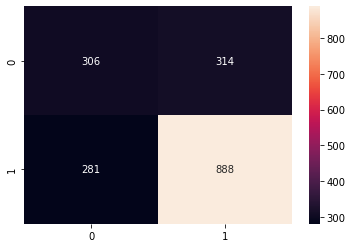

Accuracy of classifier on test set: 0.67


 =======================   Test-ROC    =========================
roc_auc = 0.6266


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.49354839 0.75962361]
average accuracy:  0.6265859985098927


In [44]:
knn = KNeighborsClassifier(
    n_neighbors =1,
    weights = "uniform", # uniform, distance
    algorithm =  'brute', # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’
)

# knn.fit(X_train, Y_train)
knn = cross_val(knn)

# pred=knn.predict(X_test)
# pred_train=knn.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(knn, X_test, Y_test)
optimal_threshold_train= optimal_thresh(knn, X_train, Y_train)

pred = (knn.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (knn.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(knn, X_train, Y_train, pred_train)
test_results(knn, X_test, Y_test, pred)

# ROC
ROC_results(knn, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(knn, Y_test, pred)

## Model 6 - Linear Discriminant Analysis

Accuracy for the fold no. 1 on the test set: 0.6927374301675978, doublecheck: 0.6927374301675978
Accuracy for the fold no. 2 on the test set: 0.6666666666666666, doublecheck: 0.6666666666666666
Accuracy for the fold no. 3 on the test set: 0.6852886405959032, doublecheck: 0.6852886405959032
Accuracy for the fold no. 4 on the test set: 0.7132216014897579, doublecheck: 0.7132216014897579
Accuracy for the fold no. 5 on the test set: 0.7243947858472998, doublecheck: 0.7243947858472998
Accuracy for the fold no. 6 on the test set: 0.702048417132216, doublecheck: 0.702048417132216
Accuracy for the fold no. 7 on the test set: 0.6996268656716418, doublecheck: 0.6996268656716418
Accuracy for the fold no. 8 on the test set: 0.7052238805970149, doublecheck: 0.7052238805970149
Accuracy for the fold no. 9 on the test set: 0.6977611940298507, doublecheck: 0.6977611940298507
Accuracy for the fold no. 10 on the test set: 0.6697761194029851, doublecheck: 0.6697761194029851
0.738785562515522
Threshold val

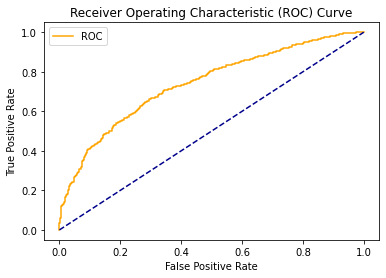

0.7410853283771599
Threshold value is: 0.6928973906989848


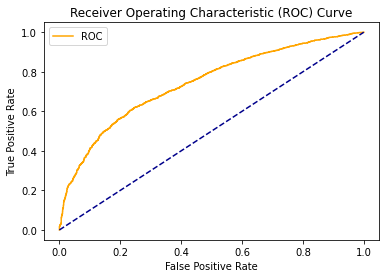


 
 =====================   Train Dataset    ======================
66.58591129332837
              precision    recall  f1-score   support

         0.0       0.51      0.75      0.61      1860
         1.0       0.83      0.62      0.71      3506

    accuracy                           0.67      5366
   macro avg       0.67      0.69      0.66      5366
weighted avg       0.72      0.67      0.67      5366



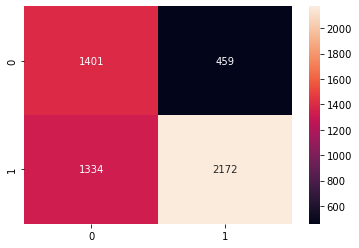

Accuracy of on training set: 0.70


 =====================   Test Dataset    =======================
67.80324203465624
              precision    recall  f1-score   support

         0.0       0.53      0.70      0.60       620
         1.0       0.81      0.66      0.73      1169

    accuracy                           0.68      1789
   macro avg       0.67      0.68      0.67      1789
weighted avg       0.71      0.68      0.69      1789



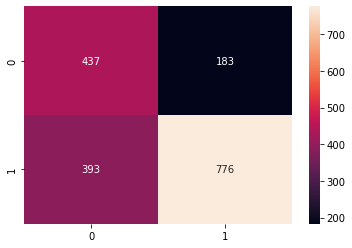

Accuracy of classifier on test set: 0.70


 =======================   Test-ROC    =========================
roc_auc = 0.7388


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.70483871 0.66381523]
average accuracy:  0.6843269681834487


In [45]:

lda = LinearDiscriminantAnalysis(
    solver = 'eigen', # solver{‘svd’, ‘lsqr’, ‘eigen’}, default=’svd’
    shrinkage= 'auto', #shrinkage‘auto’ or float, default=None
    n_components = 1,
    tol = 1e-3                       
)
# lda.fit(X_train, Y_train)
lda = cross_val(lda)

# pred=lda.predict(X_test)
# pred_train=lda.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(lda, X_test, Y_test)
optimal_threshold_train= optimal_thresh(lda, X_train, Y_train)

pred = (lda.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (lda.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(lda, X_train, Y_train, pred_train)
test_results(lda, X_test, Y_test, pred)

# ROC
ROC_results(lda, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(lda, Y_test, pred)


## Model 7- Gaussian Naive Bayes

In [ ]:
gnb = GaussianNB()

param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

nbModel_grid = GridSearchCV(estimator=gnb, param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
# nbModel_grid.fit(X_train, Y_train)
nbModel_grid = cross_val(nbModel_grid)

# best parameters
print(nbModel_grid.best_estimator_)

gnb = GaussianNB(priors=None, var_smoothing=1.0)
gnb.fit(X_train, Y_train)
      
# pred=gnb.predict(X_test)
# pred_train=gnb.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(gnb, X_test, Y_test)
optimal_threshold_train= optimal_thresh(gnb, X_train, Y_train)

pred = (gnb.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (gnb.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(gnb, X_train, Y_train, pred_train)
test_results(gnb, X_test, Y_test, pred)

# ROC
ROC_results(gnb, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(gnb, Y_test, pred)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Accuracy for the fold no. 1 on the test set: 0.6703910614525139, doublecheck: 0.6703910614525139
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Accuracy for the fold no. 2 on the test set: 0.6685288640595903, doublecheck: 0.6685288640595903
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Accuracy for the fold no. 3 on the test set: 0.6461824953445066, doublecheck: 0.6461824953445066
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Accuracy for the fold no. 4 on the test set: 0.7039106145251397, doublecheck: 0.7039106145251397
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Accuracy for the fold no. 5 on the test set: 0.6815642458100558, doublecheck: 0.6815642458100558
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
